# Dependencies

In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2 as cv
import os
import PIL
import seaborn as sns


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Dataset

### Load the train images from folders

In [3]:
img_height, img_width, img_channels = 180, 180, 3
batch_size=32
data_dir = '../data/raw/images/training'
test_data_dir = '../data/raw/images/testing'
loading_dataste_seed = 0

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2392 files belonging to 2 classes.
Using 478 files for validation.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 597 files belonging to 2 classes.


In [7]:
# shape of training data
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [18]:
classes_names = train_ds.class_names
print(classes_names)

['flip', 'notflip']


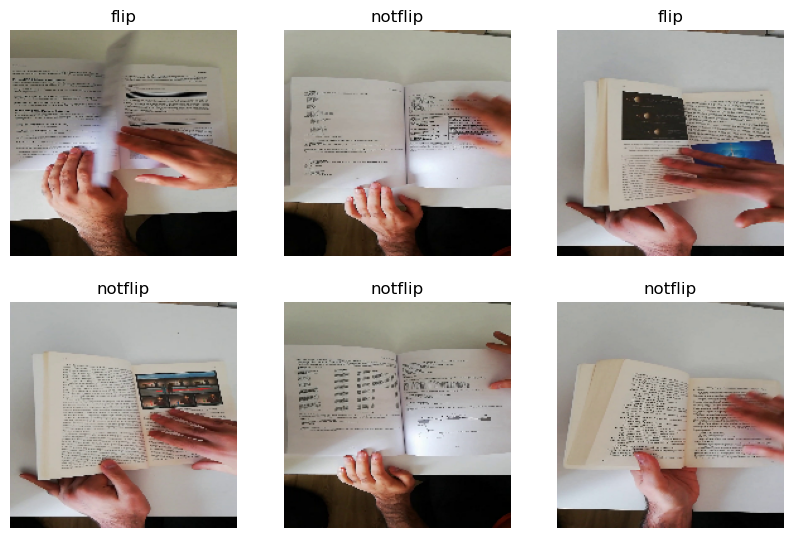

In [9]:
plt.figure(figsize=(10, 10))  # Create a new figure with a size of 10x10 inches

# Iterate over the first batch of images and labels from the train dataset
for images, labels in train_ds.take(1):
    # Iterate over each image in the batch
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot within a 3x3 grid
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
        plt.title(classes_names[labels[i]])  # Set the title as per the corresponding label
        plt.axis("off")  # Turn off the axis labels and ticks

plt.show()  # Display the plot


In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def evaluate_model(model, test_data):
    results = {}
    
    predicted_labels = []
    true_labels = []
    all_images = []
    for images, labels in test_data:
        true_labels.extend(labels.numpy())
        predicted_labels.extend(tf.argmax(model.predict(images), axis=1).numpy())

    # Accuracy
    results['accuracy'] = accuracy_score(true_labels, predicted_labels)
    
    # F1 Score
    results['f1_score'] = f1_score(true_labels, predicted_labels)
        
    cm = confusion_matrix(true_labels, predicted_labels)
    
    class_names = test_data.class_names
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return results

# Train Model

## 1. Custom

In [19]:
custom_model = models.Sequential([
    # CNN Layers 01
    layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(img_width, img_height, img_channels)
    ),
    layers.MaxPooling2D((2, 2)),
    
    # CNN Layers 02
    layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu'
    ),
    layers.MaxPooling2D((2, 2)),
    
    # Dense Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(classes_names), activation='softmax'),
])

custom_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 59168)             0         
                                                                 
 dense_1 (Dense)             (None, 64)                3

In [21]:
custom_model_history = custom_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=7
)

Epoch 1/7
60/60 [==============================] - 198s 3s/step - loss: 43.5635 - accuracy: 0.6724 - val_loss: 0.4259 - val_accuracy: 0.8096
Epoch 2/7
60/60 [==============================] - 174s 3s/step - loss: 0.2638 - accuracy: 0.8871 - val_loss: 0.2665 - val_accuracy: 0.8808
Epoch 3/7
60/60 [==============================] - 185s 3s/step - loss: 0.1432 - accuracy: 0.9436 - val_loss: 0.2154 - val_accuracy: 0.9351
Epoch 4/7
60/60 [==============================] - 163s 3s/step - loss: 0.0573 - accuracy: 0.9801 - val_loss: 0.1213 - val_accuracy: 0.9707
Epoch 5/7
60/60 [==============================] - 174s 3s/step - loss: 0.0142 - accuracy: 0.9969 - val_loss: 0.1329 - val_accuracy: 0.9665
Epoch 6/7
60/60 [==============================] - 153s 3s/step - loss: 0.0106 - accuracy: 0.9979 - val_loss: 0.0294 - val_accuracy: 0.9916
Epoch 7/7
60/60 [==============================] - 173s 3s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9958


### Evaluating The Model

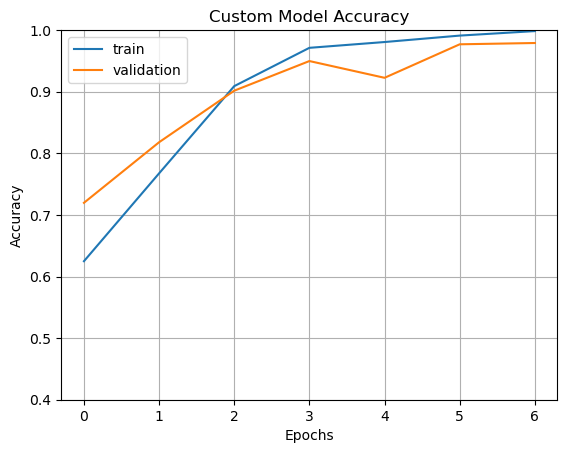

In [15]:
fig1 = plt.gcf()
plt.plot(custom_model_history.history['accuracy'])
plt.plot(custom_model_history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Custom Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

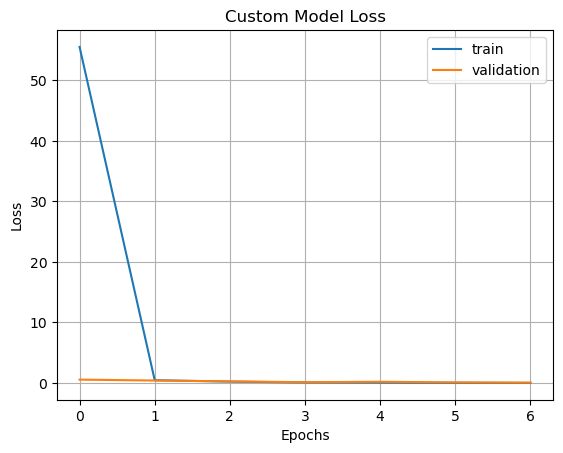

In [16]:
plt.plot(custom_model_history.history['loss'])
plt.plot(custom_model_history.history['val_loss'])
plt.grid()
plt.title('Custom Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

1/1 [==============================] - 0s 189ms/step


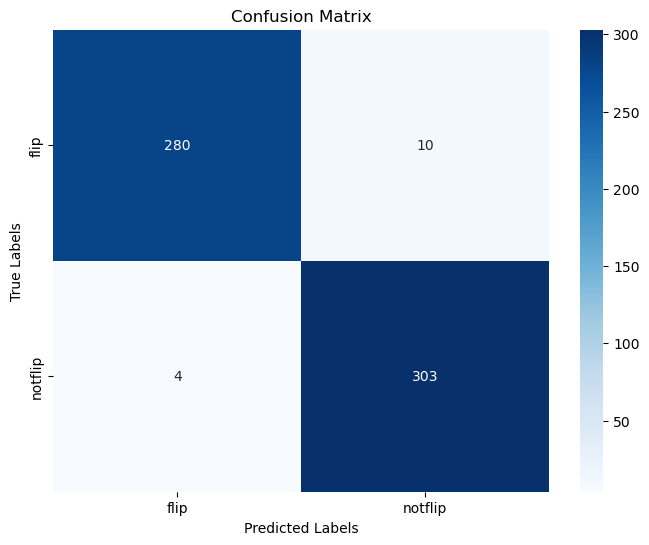

In [21]:
custom_model_evaluation = evaluate_model(custom_model, test_ds)

### Save Model

In [ ]:
custom_model_path = '../models/custom_model.h5'
custom_model.save(custom_model_path)

custom_model_size = os.path.getsize(custom_model_path) / (1024 * 1024)
print(f'Model size: {custom_model_size:.2f} MB')

## 2. ResNet

In [31]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(img_width, img_height, img_channels),
    pooling='avg',
    classes=len(classes_names),
    weights='imagenet'
)

for layer in pretrained_model.layers:
        layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

resnet_model.add(Dense(len(classes_names), activation='softmax'))

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_3 (ModuleWra  (None, 2048)             0         
 pper)                                                           
                                                                 
 module_wrapper_4 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_5 (ModuleWra  (None, 2)                1026      
 pper)                                                           
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
__________________________________

In [33]:
resnet_model_history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
60/60 [==============================] - 294s 5s/step - loss: 0.6517 - accuracy: 0.7947 - val_loss: 0.2286 - val_accuracy: 0.9184
Epoch 2/5
60/60 [==============================] - 331s 6s/step - loss: 0.1650 - accuracy: 0.9436 - val_loss: 0.1270 - val_accuracy: 0.9623
Epoch 3/5
60/60 [==============================] - 368s 6s/step - loss: 0.1012 - accuracy: 0.9671 - val_loss: 0.0842 - val_accuracy: 0.9728
Epoch 4/5
60/60 [==============================] - 286s 5s/step - loss: 0.0617 - accuracy: 0.9812 - val_loss: 0.0660 - val_accuracy: 0.9812
Epoch 5/5
60/60 [==============================] - 218s 4s/step - loss: 0.0389 - accuracy: 0.9922 - val_loss: 0.0591 - val_accuracy: 0.9770


### Evaluating The Model

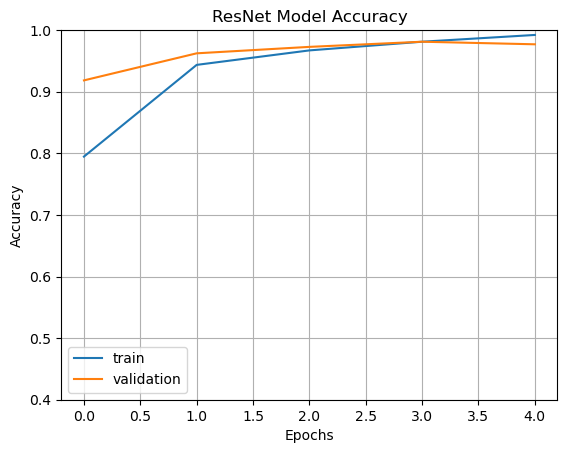

In [34]:
fig1 = plt.gcf()
plt.plot(resnet_model_history.history['accuracy'])
plt.plot(resnet_model_history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('ResNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

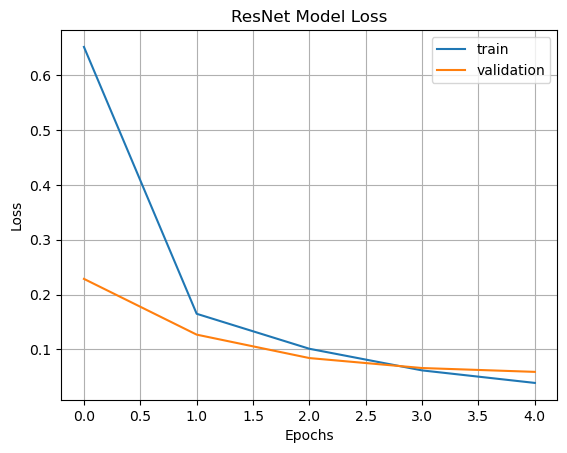

In [35]:
plt.plot(resnet_model_history.history['loss'])
plt.plot(resnet_model_history.history['val_loss'])
plt.grid()
plt.title('ResNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

1/1 [==============================] - 3s 3s/step


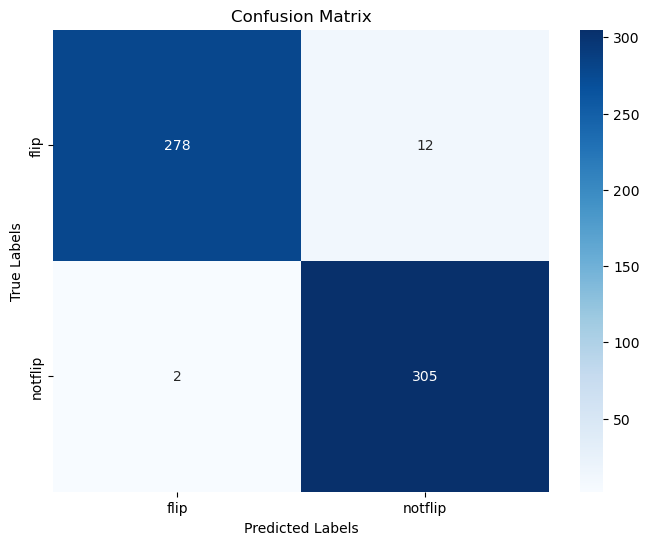

In [36]:
resnet_model_evaluation = evaluate_model(resnet_model, test_ds)

### Save model

In [58]:
resnet_model_path = '../models/resnet_model_weights.h5'
resnet_model.save_weights(resnet_model_path)

resnet_model_size = os.path.getsize(resnet_model_path) / (1024 * 1024)
print(f'Model size: {resnet_model_size:.2f} MB')

Model size: 94.22 MB


## 2. MobileNet

In [39]:
mobilenet_model = Sequential()

mobilenet_pretrained_model= tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=(img_width, img_height, img_channels),
    pooling='avg',
    weights='imagenet'
)

for layer in mobilenet_pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(mobilenet_pretrained_model)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(len(classes_names), activation='softmax'))

mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 module_wrapper_6 (ModuleWra  (None, 1280)             0         
 pper)                                                           
                                                                 
 module_wrapper_7 (ModuleWra  (None, 512)              655872    
 pper)                                                           
                                                                 
 module_wrapper_8 (ModuleWra  (None, 2)                1026      
 pper)                                                           
                                                                 
Total params: 2,914,882
Trainable params: 656,898
Non-

In [41]:
mobilenet_model_history = mobilenet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
60/60 [==============================] - 228s 3s/step - loss: 0.8767 - accuracy: 0.6625 - val_loss: 0.4385 - val_accuracy: 0.8159
Epoch 2/10
60/60 [==============================] - 117s 2s/step - loss: 0.3551 - accuracy: 0.8433 - val_loss: 0.3220 - val_accuracy: 0.8870
Epoch 3/10
60/60 [==============================] - 75s 1s/step - loss: 0.2487 - accuracy: 0.9169 - val_loss: 0.2646 - val_accuracy: 0.8996
Epoch 4/10
60/60 [==============================] - 75s 1s/step - loss: 0.1781 - accuracy: 0.9519 - val_loss: 0.1950 - val_accuracy: 0.9393
Epoch 5/10
60/60 [==============================] - 78s 1s/step - loss: 0.1364 - accuracy: 0.9603 - val_loss: 0.2087 - val_accuracy: 0.9247
Epoch 6/10
60/60 [==============================] - 69s 1s/step - loss: 0.1391 - accuracy: 0.9504 - val_loss: 0.2196 - val_accuracy: 0.8954
Epoch 7/10
60/60 [==============================] - 70s 1s/step - loss: 0.1251 - accuracy: 0.9587 - val_loss: 0.1647 - val_accuracy: 0.9351
Epoch 8/10
60/60 [

### Evaluating The Model

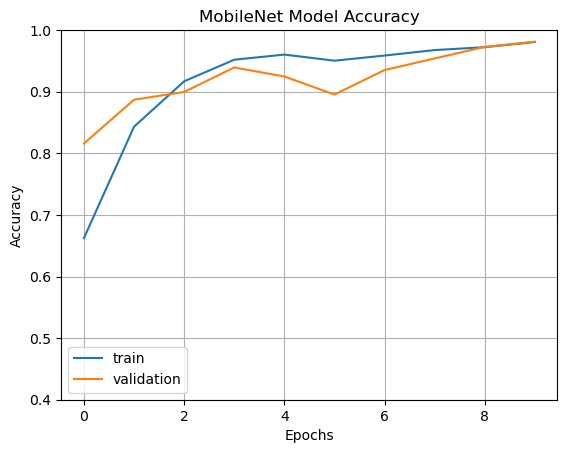

In [42]:
fig1 = plt.gcf()
plt.plot(mobilenet_model_history.history['accuracy'])
plt.plot(mobilenet_model_history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('MobileNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

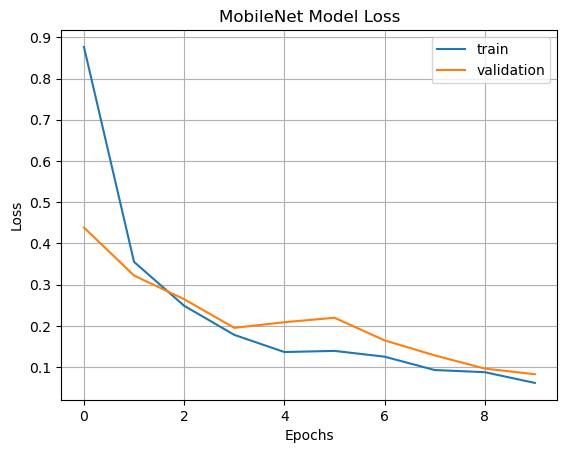

In [43]:
plt.plot(mobilenet_model_history.history['loss'])
plt.plot(mobilenet_model_history.history['val_loss'])
plt.grid()
plt.title('MobileNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

1/1 [==============================] - 4s 4s/step


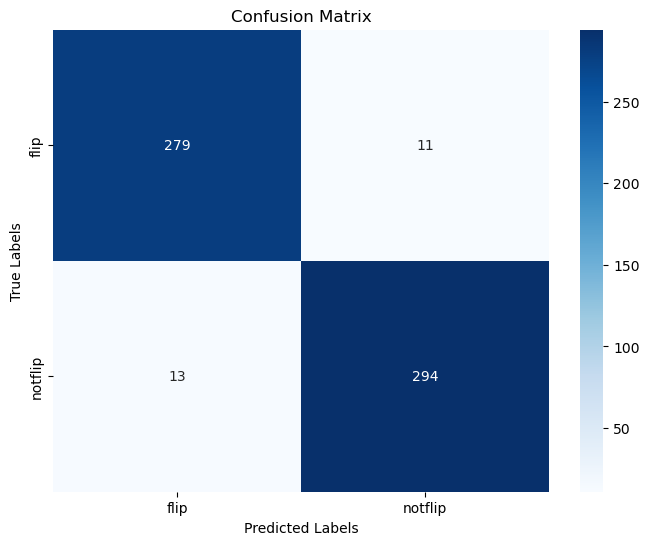

In [44]:
mobilenet_model_evaluation = evaluate_model(mobilenet_model, test_ds)

### Save Model

In [57]:
mobilenet_model_path = '../models/mobilenet_model_weights.h5'
mobilenet_model.save_weights(mobilenet_model_path)

mobilenet_model_size = os.path.getsize(mobilenet_model_path) / (1024 * 1024)
print(f'Model size: {mobilenet_model_size:.2f} MB')

Model size: 11.33 MB


# Conclusion

In [56]:
values = {
    'accuracy': [
        custom_model_evaluation['accuracy'],
        resnet_model_evaluation['accuracy'],
        mobilenet_model_evaluation['accuracy'],
    ],
    'f1_score': [
        custom_model_evaluation['f1_score'],
        resnet_model_evaluation['f1_score'],
        mobilenet_model_evaluation['f1_score'],
    ],
    'model size':[
        np.round(custom_model_size, 2),
        np.round(resnet_model_size, 2),
        np.round(mobilenet_model_size, 2),
    ]
}

df = pd.DataFrame(values, index = ['cutom_model', 'resnet', 'mobilenet'])
print(df)

             accuracy  f1_score  model size
cutom_model  0.976549  0.977419       43.50
resnet       0.976549  0.977564       11.33
mobilenet    0.959799  0.960784       94.22
